In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append("../functions")

from Utils import *
from Plotting import *
from Fitting import fit_for_all_subjects_parallel, fit_brier
from Forward import forward_fitting
from Backward import fit_model_backward


In [85]:
from Utils import *
from scipy.optimize import minimize

def forward_LL(params, resps, rewards):
    probabilities = calculate_resps_probabilities(params, resps, rewards)
    return -np.sum(protected_log(probabilities))


def calculate_resps_probabilities(params, resps, rewards):
    alpha, beta = params[:2]
    Q = np.array([0.5, 0.5])
    probabilities = np.zeros(len(resps))
    for t, (resp, reward) in enumerate(zip(resps, rewards)):
        choice_prob = softmax_func(Q, beta)
        probabilities[t] = choice_prob[resp]
        Q[resp] += alpha * (reward - Q[resp])
    return probabilities

def model_subj_conf_dist(params, confs, resp_probs):
    lbound, scale = params[0], params[1]
    hbound = scale * (5 - lbound) + lbound
    model_confs = linear_transform_on_array(resp_probs, [0, 1], [lbound, hbound])
    return mean_square_distance(confs, model_confs)


def fit_n_times(n_fitting, params_ranges, func, func_args):
    results = [minimize(func, x0=[np.random.uniform(*r) for r in params_ranges], args=func_args, bounds=params_ranges) for _ in range(n_fitting)]
    best_result = min(results, key=lambda x: x.fun if x.success else np.inf)
    return best_result.x, [result.fun for result in results if result.success]


def forward_fitting(dict_input):
    resps, rewards, confs, n_fitting, params_ranges, scale = dict_input.values()
    model_param_ranges, bound_ranges = params_ranges[:2], params_ranges[2:]

    fit_res, neg_LL_seq = fit_n_times(n_fitting, model_param_ranges, forward_LL, (resps, rewards))
    alpha, beta = fit_res[:2]

    resp_probs = calculate_resps_probabilities(fit_res, resps, rewards)
    fit_res_conf, conf_dist_seq = fit_n_times(n_fitting, bound_ranges, model_subj_conf_dist, (confs, resp_probs))

    fit_res_final = (*fit_res, *fit_res_conf)
    return fit_res_final, min(neg_LL_seq), min(conf_dist_seq), neg_LL_seq

from Utils import *
from scipy.optimize import minimize
from Forward import forward_LL

def calculate_choice_probabilities(Q, beta, resps, rewards, alpha):
    """Calculate choice probabilities and update Q values based on responses and rewards."""
    task_length = len(resps)
    probabilities = np.zeros(task_length)
    for t in range(task_length):
        choices_probability = softmax_func(Q, beta)
        probabilities[t] = choices_probability[resps[t]]
        prediction_error = rewards[t] - Q[resps[t]]
        Q[resps[t]] += alpha * prediction_error
    return probabilities

def backward_distance(params, resps, rewards, confs, scale):
    """Calculate mean squared distance between experimental and model confidence levels."""
    alpha, beta = params[:2]
    Q = np.array([.5, .5])
    
    probabilities = calculate_choice_probabilities(Q, beta, resps, rewards, alpha)
    
    if scale:
        lbound, hbound = params[2], params[3] * (5 - params[2]) + params[2]
        model_confs = linear_transform_on_array(probabilities, [0, 1], [lbound, hbound])
    else:
        model_confs = linear_transform_on_array(probabilities, [0, 1], [1, 5])
    
    return mean_square_distance(confs, model_confs)

def fit_model_backward(dict_input):
    """Fit model by minimizing the backward distance and calculate negative log-likelihood."""
    resps, rewards, confs, scale = dict_input["resp"], dict_input["reward"], dict_input["cj"], dict_input["scale"]
    n_fitting, params_ranges = dict_input["n_fitting"], dict_input["params_ranges"]
    
    best_fit, min_dist, neg_LL = None, np.inf, None
    dists = []
    for _ in range(n_fitting):
        initial_params = [np.random.uniform(*range_) for range_ in params_ranges]
        result = minimize(backward_distance, initial_params, args=(resps, rewards, confs, scale), bounds=params_ranges)
        
        if result.success and result.fun < min_dist:
            min_dist, best_fit = result.fun, result.x
            neg_LL = forward_LL(best_fit, resps, rewards)
        dists.append(result.fun)
    
    return best_fit, neg_LL, min_dist, dists

In [91]:
dfs = []

for cond in ["lc1", "hc"]:
    chance_level_subjects = [45634, 46069, 46279, 46303, 46651, 47398]
    data = preprocess_data("../data/twoArmedandit_with_confidence.csv", chance_level_subjects, "induction", cond)
    subjects = data["sub"].unique()
    n_fitting = 200
    n_threads = 100

    backward_params_ranges = [[0, 1], [0, 100], [1, 5], [0, 1]]
    backward_res = fit_for_all_subjects_parallel(backward_params_ranges, n_threads, n_fitting, subjects, data, fit_model_backward, True)
    
    res = []
    fixed_shape = 200

    for i in range(len(forward_res)):
        array = np.minimum.accumulate(backward_res[i][-1])
        array = array - array[-1]
        # Pad the array to the fixed shape with np.inf
        if len(array) < fixed_shape:
            padded_array = np.pad(array, (0, fixed_shape - len(array)), constant_values=0.0)
        else:
            padded_array = array[:fixed_shape]  # Truncate if necessary
        res.append(padded_array)

    # Stack into a 2D array
    res = np.vstack(res)

    # Prepare a DataFrame from `res`
    data_frames = []
    for i in range(res.shape[0]):  # Iterate over rows of `res`
        df = pd.DataFrame({
            'x': np.arange(fixed_shape),  # X values from 0 to 200
            'y': res[i, :],  # Y values from the row
            'subject': i,  # Identifier for the source array
            "cond": cond
        })
        data_frames.append(df)

    # Combine all data into a single DataFrame
    combined_df = pd.concat(data_frames, ignore_index=True)
    dfs.append(combined_df)
back_df = pd.concat(dfs, ignore_index=True)

In [93]:
back_df.to_csv("../results/backward_error_seq.csv")

In [49]:
dfs = []

np.random.seed(0)


for cond in ["lc1", "hc"]:
    chance_level_subjects = [45634, 46069, 46279, 46303, 46651, 47398]
    data = preprocess_data("../data/twoArmedandit_with_confidence.csv", chance_level_subjects, "induction", cond)
    subjects = data["sub"].unique()
    n_fitting = 200
    n_threads = 100

    forward_params_ranges = [[0, 1], [0, 100], [1, 5], [0, 1]]

    forward_res = fit_for_all_subjects_parallel(forward_params_ranges, n_threads, 200, subjects, data, forward_fitting, True)
    
    res = []
    fixed_shape = 200

    for i in range(len(forward_res)):
        array = np.minimum.accumulate(forward_res[i][-1])
        array = array - array[-1]
        # Pad the array to the fixed shape with np.inf
        if len(array) < fixed_shape:
            padded_array = np.pad(array, (0, fixed_shape - len(array)), constant_values=0.0)
        else:
            padded_array = array[:fixed_shape]  # Truncate if necessary
        res.append(padded_array)

    # Stack into a 2D array
    res = np.vstack(res)

    # Prepare a DataFrame from `res`
    data_frames = []
    for i in range(res.shape[0]):  # Iterate over rows of `res`
        df = pd.DataFrame({
            'x': np.arange(fixed_shape),  # X values from 0 to 200
            'y': res[i, :],  # Y values from the row
            'subject': i,  # Identifier for the source array
            "cond": cond
        })
        data_frames.append(df)

    # Combine all data into a single DataFrame
    combined_df = pd.concat(data_frames, ignore_index=True)
    dfs.append(combined_df)
df = pd.concat(dfs, ignore_index=True)

In [111]:
fwd_df[fwd_df["cond"]="hc"]

SyntaxError: invalid syntax (3105532241.py, line 1)

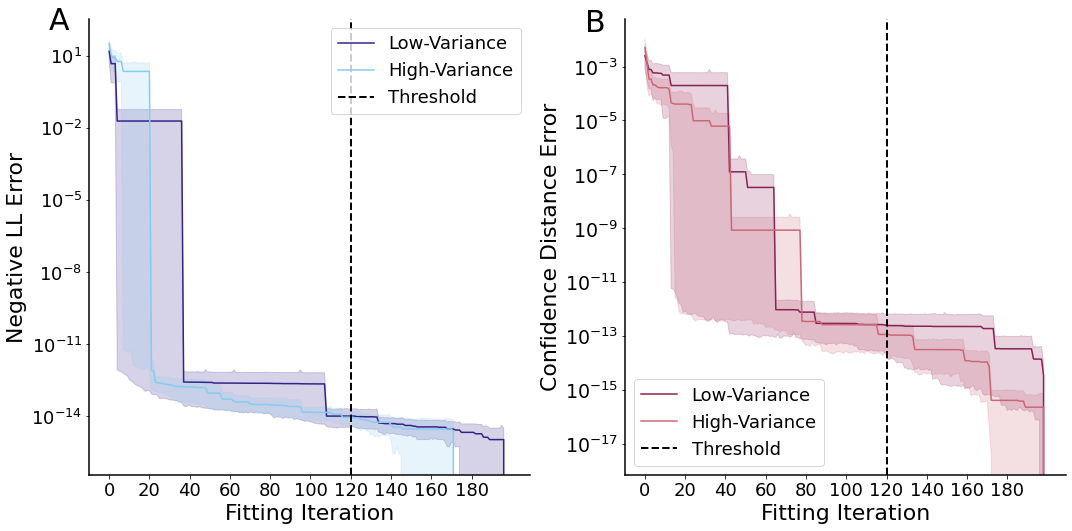

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# # Load data
# fwd_df = pd.read_csv("../results/forward_df_neg_ll_seq.csv")
# back_df = pd.read_csv("../results/backward_error_seq.csv")

# # Rename conditions in dataframes
# fwd_df['cond'] = fwd_df['cond'].replace({'lc1': 'High-Variance', 'hc': 'Low-Variance'})
# back_df['cond'] = back_df['cond'].replace({'lc1': 'High-Variance', 'hc': 'Low-Variance'})

# Create the figure
plt.figure(figsize=(15, 7.5))

# First subplot
plt.subplot(1, 2, 1)
plt.text(-30, 120, "A", fontsize=30)

sns.lineplot(data=fwd_df, x="x", y="y", hue="cond", palette=["#332288", "#88CCEE"], hue_order=["Low-Variance", "High-Variance"])
plt.axvline(x=120, linestyle="--", linewidth=2, color="k", label="Threshold")
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.ylabel('Negative LL Error', fontsize=22)
plt.xlabel('Fitting Iteration', fontsize=22)
plt.yticks(fontsize=18)
plt.xticks(ticks=np.arange(0, 200, 20), fontsize=18)
ax1 = plt.gca()
for axis in ['top', 'bottom', 'left', 'right']:
    ax1.spines[axis].set_linewidth(1.5)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
plt.legend(fontsize=18)


# Second subplot
plt.subplot(1, 2, 2)

sns.lineplot(data=back_df, x="x", y="y", hue="cond", palette=["#882255", "#CC6677"], hue_order=["Low-Variance", "High-Variance"])
plt.axvline(x=120, linestyle="--", linewidth=2, color="k", label="Threshold")
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.ylabel('Confidence Distance Error', fontsize=22)
plt.xlabel('Fitting Iteration', fontsize=22)
plt.yticks(fontsize=19)
plt.xticks(ticks=np.arange(0, 200, 20), fontsize=18)
ax2 = plt.gca()
for axis in ['top', 'bottom', 'left', 'right']:
    ax2.spines[axis].set_linewidth(1.5)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
plt.legend(fontsize=18)
plt.text(-30, 2e-2, "B", fontsize=30)

plt.tight_layout()
plt.savefig("../figs/fit_stability-choice-conf.png", dpi=400, bbox_inches = "tight")

plt.show()

In [ ]:
import seaborn as sns
import pandas as pd

# Prepare data for seaborn plot
data = pd.DataFrame(res, columns=np.arange(fixed_shape))

# Calculate mean and standard deviation
mean_values = data.mean(axis=0)
std_dev = data.std(axis=0)

# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x=np.arange(fixed_shape), y=mean_values, label='Mean', linewidth=2)
# plt.fill_between(np.arange(fixed_shape), mean_values - std_dev, mean_values + std_dev, alpha=0.3, label='±1 Std Dev', color='blue')

# Customize the plot
plt.xlabel('X-axis (0 to 200)', fontsize=12)
plt.ylabel('Y-axis (Values)', fontsize=12)
plt.title('Mean Plot with Error Bands (Seaborn)', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
forward_params_ranges = [[0, 1], [0, 100], [1, 5], [0, 1]]
forward_res = fit_for_all_subjects_parallel(forward_params_ranges, n_threads, n_fitting, subjects, data, forward_fitting, True)
forward_df = make_df_after_fitting(forward_res, ["alpha", "beta", "lbound", "bound_range"], subjects)
forward_df["hbound"] = (5 - forward_df["lbound"]) * forward_df["bound_range"] + forward_df["lbound"]
# forward_df.to_csv("../results/forward_df.csv")


In [ ]:
len(forward_res)

In [ ]:
backward_params_ranges = [[0, 1], [0, 100], [1, 5], [0, 1]]
backward_res = fit_for_all_subjects_parallel(backward_params_ranges, n_threads, n_fitting, subjects, data, fit_model_backward, True)
backward_df = make_df_after_fitting(backward_res, ["alpha", "beta", "lbound", "bound_range"], subjects)
backward_df["hbound"] = (5 - backward_df["lbound"]) * backward_df["bound_range"] + backward_df["lbound"]
backward_df.to_csv("../results/backward_df.csv")

In [ ]:
backward_params_ranges_unscaled = [[0, 1], [0, 100]]
backward_res_unscaled = fit_for_all_subjects_parallel(backward_params_ranges_unscaled, n_threads, n_fitting, subjects, data, fit_model_backward, False)
backward_df_unscaled = make_df_after_fitting(backward_res_unscaled, ["alpha", "beta"], subjects)
backward_df_unscaled["lbound"], backward_df_unscaled["hbound"] = 1, 5
backward_df_unscaled.to_csv("../results/backward_df_unscaled.csv")

In [ ]:
from Fitting import fit_brier

brier_res = fit_brier(subjects, data, n_threads=n_threads)
scaled_brier_ls = []
scaled_brier_lb = []
scaled_brier_ub = []
for res in brier_res:
    scaled_brier_ls.append(res[1])
    scaled_brier_lb.append(res[0][0])
    scaled_brier_ub.append(res[0][1] * (1 - res[0][0]) + res[0][0])
scaled_brier_df = pd.DataFrame(
    list(zip(subjects, scaled_brier_lb, scaled_brier_ub, scaled_brier_ls)),
    columns=["subject", "lb", "ub", "brier"],
)
scaled_brier_df["scaled_QSR"] = 1 - scaled_brier_df["brier"]
scaled_brier_df.to_csv("../results/scaled_brier_df.csv")